# ODE NHP Test

Test ODE-GRU network with NHP loss on synthetic data

In [1]:
import math
import numpy as np
import torch
import hotpp
from hotpp.data import PaddedBatch
from matplotlib import pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset

Synthetic dataset with a predefined distribution of time delta.

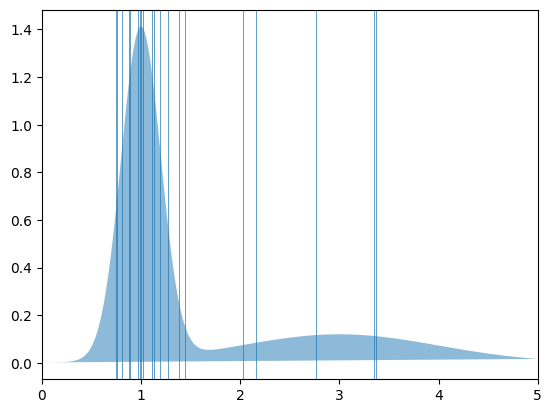

In [2]:
class DTDistribution:
    def __init__(self):
        self.means = torch.tensor([1, 3]).float()
        self.stds = torch.tensor([0.2, 1])
        self.probs = torch.tensor([0.7, 0.3])

    @property
    def entropy(self):
        n = 10000
        s = self.sample(10000)
        return -self.log_pdf(s).mean()

    @property
    def expectation(self):
        return (self.means * self.probs).sum()

    def log_pdf(self, dt):
        shape = [len(self.means)] + [1] * dt.ndim
        means = self.means.reshape(*shape)
        stds = self.stds.reshape(*shape)
        probs = self.probs.reshape(*shape)
        log_pdfs = -0.5 * (2 * math.pi * stds ** 2).log() - (means - dt) ** 2 / 2 / stds ** 2
        return torch.logsumexp(log_pdfs + probs.log(), 0)

    def sample(self, size):
        components = torch.multinomial(self.probs, size, replacement=True)  # S.
        sample = (torch.randn(size, 1) * self.stds + self.means).take_along_dim(components[:, None], 1).squeeze(1)
        return sample.clip(min=0)

    def plot(self, sample_size=20, ax=None):
        if ax is None:
            ax = plt.gca()
        x_min = 0
        x_max = self.means.max().item() + self.stds.max().item() * 2
        ax.set_xlim(x_min, x_max)
        if sample_size:
            sample = self.sample(sample_size)
            for x in sample:
                ax.axvline(x, 0, 1, linewidth=0.5)

        xs = torch.linspace(x_min, x_max, 1000)
        pdfs = self.log_pdf(xs).exp()
        ax.fill(xs, pdfs, alpha=0.5)

DTDistribution().plot()

**Create batch**

Each sequences is composed of two timestamps: 0 and sampled. All labels are identical.

In [3]:
batch_size = 10000
time_deltas = DTDistribution().sample(batch_size).reshape(batch_size)  # (B).
time_deltas = torch.stack([torch.zeros_like(time_deltas), time_deltas], 1)  # (B, 2)
time_deltas = PaddedBatch(time_deltas, torch.full([batch_size], 2, dtype=torch.long))

batch = PaddedBatch(
    {
        "timestamps": time_deltas.payload.cumsum(1),
        "labels": torch.zeros(*time_deltas.shape, dtype=torch.long)
    },
    time_deltas.seq_lens
)
print(batch.shape)

torch.Size([10000, 2])


# Model

In [4]:
module = hotpp.modules.NextItemModule(
    seq_encoder=hotpp.nn.RnnEncoder(
        embeddings={"labels": {"in": 1, "out": 1}},
        rnn_partial=lambda dim: hotpp.nn.ODEGRU(dim, 16, num_diff_layers=3),
    ),
    head_partial=lambda idim, odim: hotpp.nn.Head(idim, odim, hidden_dims=[16]),
    loss=hotpp.losses.NHPLoss(1, max_delta=5, max_intensity=5, expectation_steps=10000),
    optimizer_partial=lambda p: torch.optim.Adam(p, lr=0.001)
).to(DEVICE).eval()

batch = batch.to(DEVICE)

# Train

In [5]:
module.train()
print("Entropy", DTDistribution().entropy.item())
optimizer = module.configure_optimizers()
for step in range(1000):
    loss = module.training_step((batch, None), None)
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(module.parameters(), 1)
    if step % 200 == 0:
        print(f"Step {step}, Loss {loss.item():.2f}, Grad {grad_norm.item():.2f}")
    optimizer.step()
module.eval()
pass

Entropy 0.8105257153511047


/home/ivan/.venv/esp/lib/python3.12/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Step 0, Loss 1.48, Grad 0.19
Step 200, Loss 0.85, Grad 0.23
Step 400, Loss 0.80, Grad 0.37
Step 600, Loss 0.79, Grad 0.42
Step 800, Loss 0.80, Grad 0.31


# Visualize results

In [6]:
prefix = PaddedBatch({
    "timestamps": batch.payload["timestamps"][:1, :1],
    "labels": batch.payload["labels"][:1, :1]
}, torch.ones_like(batch.seq_lens[:1]))

with torch.no_grad():
    outputs = module(prefix)
print("Expected time delta:", DTDistribution().expectation)
print("Predicted time delta:", outputs.payload["timestamps"].item())

Expected time delta: tensor(1.6000)
Predicted time delta: 1.5147813558578491


In [7]:
class Density:
    """Simple intensity-to-density mapper."""
    def __init__(self, intensity, sample_size=100):
        self.i = intensity
        self.s = torch.linspace(0, 1, sample_size)

    def __call__(self, deltas):
        means = self.i(deltas[..., None] * self.s.to(deltas.device)).mean(-1)  # (...).
        integrals = means * deltas
        log_values = self.i(deltas).log() - integrals
        values = log_values.exp()
        return values

class IntensityFN:
    """Intensity function wrapper."""
    def __init__(self, deltas, intensities):
        self.deltas = deltas.cpu().numpy()
        self.intensities = intensities.cpu().numpy()

    def __call__(self, deltas):
        values = np.interp(deltas.cpu().numpy(), self.deltas, self.intensities)
        values = torch.tensor(values, device=deltas.device, dtype=deltas.dtype)
        return values

def get_density(deltas, intensities):
    """Convert intensity to density."""
    return Density(IntensityFN(deltas, intensities))(deltas)

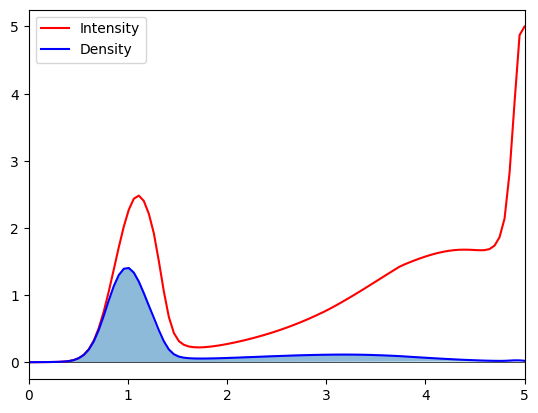

In [8]:
with torch.no_grad():
    state = module.encode(prefix)[1]

inter_times = torch.linspace(0, 5, 100)
inter_times = PaddedBatch(inter_times[None, None], torch.tensor([1])).to(DEVICE)
with torch.no_grad():
    inter = module._loss.interpolator(state, inter_times).payload
    intensity = module._loss.intensity(inter)[0, 0, :, 0]
    density = get_density(inter_times.payload[0, 0], intensity)

DTDistribution().plot(sample_size=None)
plt.axhline(0, color="k", linewidth=0.5)
plt.plot(inter_times.payload[0, 0].cpu(), intensity.cpu(), label="Intensity", c="red")
plt.plot(inter_times.payload[0, 0].cpu(), density.cpu(), label="Density", c="blue")
plt.legend()
plt.show()

# Conclusion
* Don't use batchnorm in the models' head